In [517]:
import torch 
import numpy as np
import torch.nn as nn
import moviepy.editor as mpy
import matplotlib.pyplot as plt

from moviepy.video.io.bindings import mplfig_to_npimage

In [575]:
class LinearBlock(nn.Module):
    def __init__(self, din, dout, act='relu', lim=2):
        """
        Args:
            din (int): input dimension for the layer
            dout (int): output dimension for the layer
            act (str): string of pytorch activation function
            lim (float): upper and lower limit of initialization
                for the linear layer weights and biases
        """
        super().__init__()
        self.lin = nn.Linear(din, dout)
        self.act = self._activation_fn(act)
        
        # important for quality of results
        nn.init.uniform_(self.lin.weight, -lim, lim)
            
    def _activation_fn(self, name):
        """Gets the activation function callable
        
        Args:
            name (str): name of the pytorch function
            
        Returns:
            callable: activation function
        """
        try:
            return eval(f"torch.{name}")
        except:
            return eval(f"F.{name}")
    
    def forward(self, x):
        """Forward pass
        
        Args:
            x (torch.Tensor): layer input of shape (*, din)
            
        Returns:
            torch.Tensor: layer output of shape (*, dout)
        """
        return self.act(self.lin(x))


class CPPN(nn.Module):
    
    def __init__(
        self, 
        in_dim, 
        layers,
        activations=None, 
        zdim=16, 
        scale=1, 
        final_activation='sigmoid',
        init_limit=5,
    ):
        """
        Args:
            in_dim (int): input dimension of data
            layers (Iterable[int]): list of the number of nodes per hidden layer
            radius (float): radius of the planet
            activations (Iterable[str]): list of activations for each hidden layer
            zdim (int): latent dimension
            ffeats (int): number of fourier features, must be greater than 0 to use
            ffscale (float): scale of fourier feature mapping (higher -> high frequencies)
            scale (float): scale of latent features (zoom)
            final_activation (Union[str, callable]): Final activation to apply to NN output
            init_limit (float): Upper and lower limit of init values for layer weights
        """
        super().__init__()
        self.layers = layers
        self.zdim = zdim
        self.init_limit = init_limit
        self.scale = scale
        self.acts = activations
        self.in_dim = in_dim
        
        # define hidden layer dimensions
        self.hidden = list(zip(layers, layers[1:]))
        
        # activation functions
        if self.acts is None:
            self.acts = ['tanh'] * len(layers)
        else:
            assert len(self.acts) == len(layers), (
                f"num activation functions {len(self.acts)} != num layers {len(layers)}"
            )
            
        self.init_act = self._activation_fn(self.acts[0])
        self.final_act = (
            final_activation if hasattr(final_activation, '__call__')
            else (  # if it's not a str or callable, default to identity
                self._activation_fn(final_activation) if isinstance(final_activation, str)
                else lambda x: x
            )
        )
            
        # initialize layers
        self.xlayer = nn.Linear(1, layers[0], bias=False)
        self.ylayer = nn.Linear(1, layers[0], bias=False)
        self.rlayer = nn.Linear(1, layers[0], bias=False)
        self.latent_layer = nn.Linear(zdim, layers[0])
        self.mlp = self._create_layers()
        
        print(f"\n{'-'*30} [ARCHITECTURE] {'-'*30}\n{self}{'-'*75}")
        
    def _activation_fn(self, name):
        """Gets the activation function callable
        
        Args:
            name (str): name of the pytorch function
            
        Returns:
            callable: activation function
        """
        try:
            return eval(f"torch.{name}")
        except:
            return eval(f"F.{name}")
        
    def _create_layers(self):
        """Initialize the hidden layers of NN
        
        Returns:
            nn.Sequential: NN module for the hidden layers
        """
        layers = [
            LinearBlock(i, o, a, lim=self.init_limit) 
            for (i, o), a in zip(self.hidden, self.acts[1:])
        ]   
        layers.append(nn.Linear(self.layers[-1], 5))
        return nn.Sequential(*layers)
    
    def _latent_code(self, H, W):
        """Generate latent code for inference
        
        Args:
            H (int): size of domain along dim 0
            W (int): size of domain along dim 1
            dist_param (float[Optional]): parameter for the latent distribution
            
        Returns:
            torch.Tensor: latent code in a grid of shape (H, W, zdim)
        """
        return torch.FloatTensor(1, self.zdim).uniform_(-1, 1).repeat(H, W, 1)
    
    def forward(self, grid, latent=None, scale=1):
        if latent is None:
            latent = self._latent_code(*grid.shape[:2])
            
        scaled = scale * grid
        x, y = scaled[..., 0].reshape(-1, 1), scaled[..., 1].reshape(-1, 1)
        r = torch.sqrt(x**2 + y**2)

        coords = self.xlayer(x) + self.ylayer(y) + self.rlayer(r)
        coords = coords.reshape(*grid.shape[:2], -1)
        coords = coords + self.latent_layer(scale * latent)
        coords = self.init_act(coords)
        coords = self.mlp(coords)
            
        return self.final_act(coords)
            

In [576]:
mlp = CPPN(
    in_dim=2, 
    layers=[64] * 4, 
    activations=['tanh', 'softplus', 'tanh', 'tanh'],
    zdim=8,
    final_activation='tanh',
    init_limit=5,
)


------------------------------ [ARCHITECTURE] ------------------------------
CPPN(
  (xlayer): Linear(in_features=1, out_features=64, bias=False)
  (ylayer): Linear(in_features=1, out_features=64, bias=False)
  (rlayer): Linear(in_features=1, out_features=64, bias=False)
  (latent_layer): Linear(in_features=8, out_features=64, bias=True)
  (mlp): Sequential(
    (0): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): LinearBlock(
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): Linear(in_features=64, out_features=5, bias=True)
  )
)---------------------------------------------------------------------------


In [577]:
resolution = 512
Y = np.linspace(-1, 1, resolution)
X = np.linspace(-1, 1, resolution)
X, Y = np.meshgrid(X, Y)  

grid = torch.from_numpy(np.stack([X, Y], axis=-1)).float()
out = mlp(grid, scale=1).squeeze()

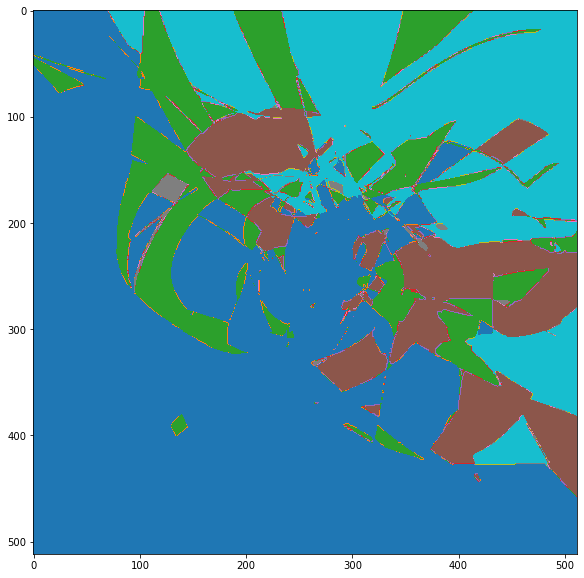

In [580]:
plt.figure(figsize=(10,10))
plt.imshow(out.argmax(-1).detach().numpy(), cmap='tab10');

t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]

MoviePy - Building file videos/foo.gif with imageio.


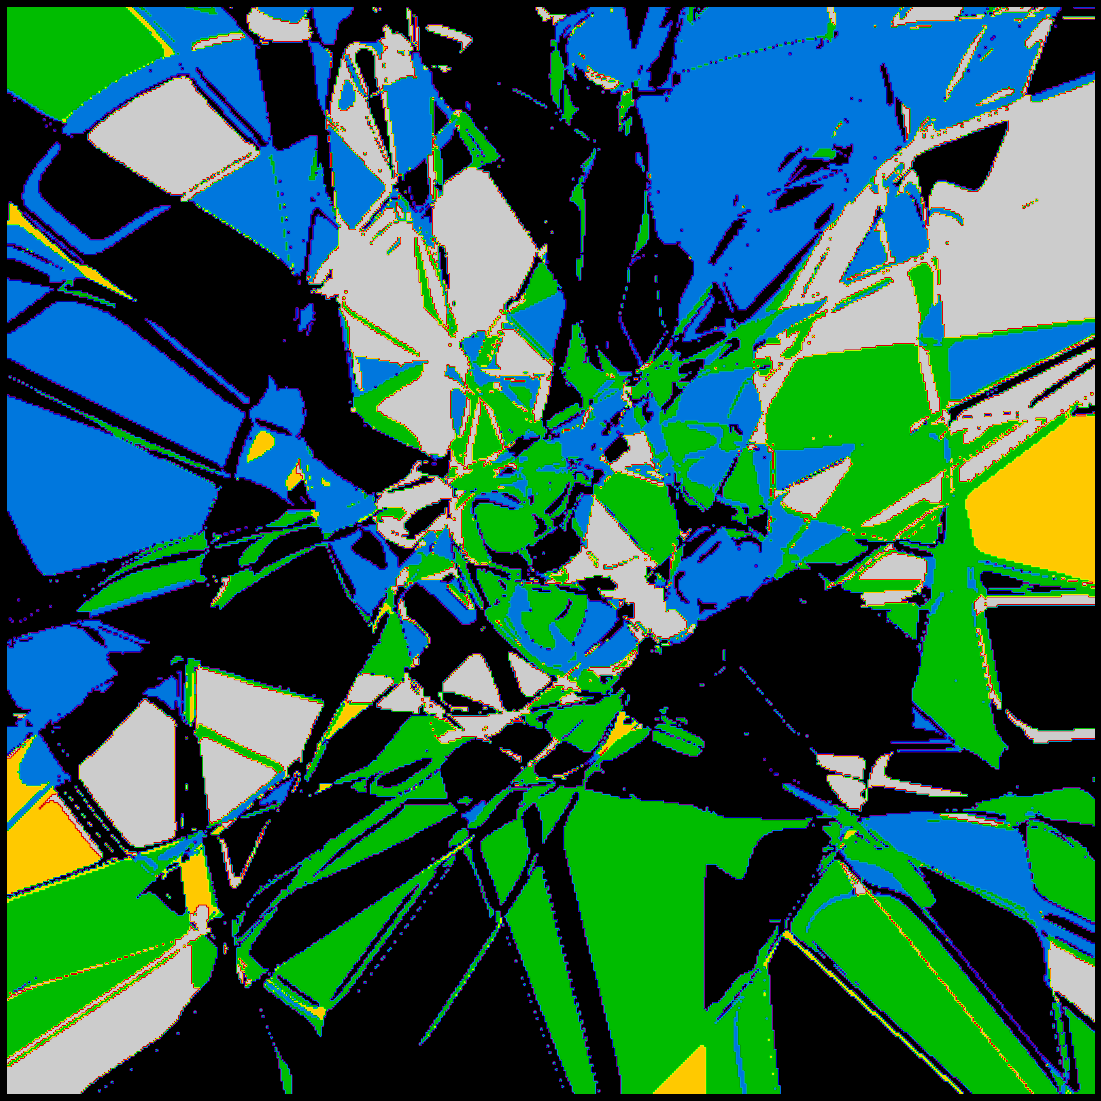

In [579]:
duration = 5

z1 = torch.FloatTensor(1, mlp.zdim).uniform_(-1, 1).repeat(*grid.shape[:2], 1)
z2 = torch.FloatTensor(1, mlp.zdim).uniform_(-1, 1).repeat(*grid.shape[:2], 1)

img = mlp(grid, latent=z1, scale=1)

fig_mpl, ax = plt.subplots(1, figsize=(20, 20), facecolor='black')
ax.set_axis_off()

im = img.argmax(-1).detach().numpy()
image = ax.imshow(im, cmap='nipy_spectral')

def make_interp_frame(t):
    step = t / duration
    mix = np.sin(np.pi * step)
    img = mlp(grid, scale=100, latent=z1 + mix * (z2 - z1))

    im = img.argmax(-1).detach().numpy()
    image.set_data(im)
    return mplfig_to_npimage(fig_mpl)

animation = mpy.VideoClip(make_interp_frame, duration=duration)
animation.write_gif("videos/foo.gif", fps=30)